In [1]:
import sage.logic.propcalc as pc
import itertools as it
import numpy.random as rn
from sage.plot.histogram import Histogram
import numpy as np

from scipy.integrate import odeint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/sagemath/local/lib/python2.7/site-packages/traitlets/traitlets.py:770: DeprecationWarning: A parent of InlineBackend._config_changed has adopted the new @observe(change) API
  clsname, change_or_name), DeprecationWarning)


In [2]:
def norm(x):
    mm = max([abs(xx) for xx in x])
    if mm == 0: mm = 1
    return [xx/mm for xx in x] 

In [3]:
Rules = """E2F1 *= (~pRB & E2F1) | (~pRB & Myc)
CyclinD1 *= (~p21 & Myc) | (~pRB & Myc & E2F1) | (~p21 & E2F1) | (~pRB & E2F1 & CyclinD1)
p21 *= ~CyclinE
Myc *= ~pRB & E2F1
CyclinE *= ~pRB & ~p27Kip1 & E2F1
pRB *= (p27Kip1 & ~CyclinD1) | (~CyclinE & ~CyclinD1)
p27Kip1 *= ~CyclinE & ~CyclinD1"""

In [4]:
# Parse Boolean rules
rdict = {}
for line in Rules.split('\n'):
    lr = line.split('*=')
    rdict[lr[0].strip()] = pc.formula(lr[1])
    
for r in rdict: print r, "*=", rdict[r]

E2F1 *= (~pRB&E2F1)|(~pRB&Myc)
CyclinE *= ~pRB&~p27Kip1&E2F1
pRB *= (p27Kip1&~CyclinD1)|(~CyclinE&~CyclinD1)
p27Kip1 *= ~CyclinE&~CyclinD1
p21 *= ~CyclinE
CyclinD1 *= (~p21&Myc)|(~pRB&Myc&E2F1)|(~p21&E2F1)|(~pRB&E2F1&CyclinD1)
Myc *= ~pRB&E2F1


In [5]:
# Convert rules to HillCubes rate functions
xdict={r:var('x_'+r) for r in rdict}
RF = {}
for r in rdict:
    k = {}
    n = {}
    H = {}
    
    RF[r] = -xdict[r]
    
    varnames = str(rdict[r].truthtable(end=0)).split()[0:-1]
    
    for ncomb in range(len(varnames)+1):
        for comb in it.combinations(varnames,ncomb):
            st = {v: v in list(comb) for v in varnames}
            hprod = 0
            if rdict[r].evaluate(st):           
                hprod = 1
                for v in varnames:
                    rv = r + '_' + v
                    k[rv] = var('k_' + rv)
                    n[rv] = var('n_' + rv)
                    
                    if st[v]:
                        hprod *= xdict[v]^n[rv] / (k[rv]^n[rv] + xdict[v]^n[rv])
                    else:
                        hprod *= k[rv]^n[rv] / (k[rv]^n[rv] + xdict[v]^n[rv])
            RF[r] += hprod
    RF[r] = ((RF[r]+xdict[r]).numerator()/(RF[r]+xdict[r]).denominator()) - xdict[r]

In [6]:
for r in RF.keys():
    show(RF[r])

-x_E2F1 + (k_E2F1_Myc^n_E2F1_Myc*k_E2F1_pRB^n_E2F1_pRB*x_E2F1^n_E2F1_E2F1 + k_E2F1_E2F1^n_E2F1_E2F1*k_E2F1_pRB^n_E2F1_pRB*x_Myc^n_E2F1_Myc + k_E2F1_pRB^n_E2F1_pRB*x_E2F1^n_E2F1_E2F1*x_Myc^n_E2F1_Myc)/((k_E2F1_E2F1^n_E2F1_E2F1 + x_E2F1^n_E2F1_E2F1)*(k_E2F1_Myc^n_E2F1_Myc + x_Myc^n_E2F1_Myc)*(k_E2F1_pRB^n_E2F1_pRB + x_pRB^n_E2F1_pRB))

-x_CyclinE + k_CyclinE_p27Kip1^n_CyclinE_p27Kip1*k_CyclinE_pRB^n_CyclinE_pRB*x_E2F1^n_CyclinE_E2F1/((k_CyclinE_E2F1^n_CyclinE_E2F1 + x_E2F1^n_CyclinE_E2F1)*(k_CyclinE_p27Kip1^n_CyclinE_p27Kip1 + x_p27Kip1^n_CyclinE_p27Kip1)*(k_CyclinE_pRB^n_CyclinE_pRB + x_pRB^n_CyclinE_pRB))

-x_pRB + (k_pRB_CyclinD1^n_pRB_CyclinD1*k_pRB_CyclinE^n_pRB_CyclinE*k_pRB_p27Kip1^n_pRB_p27Kip1 + k_pRB_CyclinD1^n_pRB_CyclinD1*k_pRB_CyclinE^n_pRB_CyclinE*x_p27Kip1^n_pRB_p27Kip1 + k_pRB_CyclinD1^n_pRB_CyclinD1*x_CyclinE^n_pRB_CyclinE*x_p27Kip1^n_pRB_p27Kip1)/((k_pRB_CyclinD1^n_pRB_CyclinD1 + x_CyclinD1^n_pRB_CyclinD1)*(k_pRB_CyclinE^n_pRB_CyclinE + x_CyclinE^n_pRB_CyclinE)*(k_pRB_p27Kip1^n_pRB_p27Kip1 + x_p27Kip1^n_pRB_p27Kip1))

-x_p27Kip1 + k_p27Kip1_CyclinD1^n_p27Kip1_CyclinD1*k_p27Kip1_CyclinE^n_p27Kip1_CyclinE/((k_p27Kip1_CyclinD1^n_p27Kip1_CyclinD1 + x_CyclinD1^n_p27Kip1_CyclinD1)*(k_p27Kip1_CyclinE^n_p27Kip1_CyclinE + x_CyclinE^n_p27Kip1_CyclinE))

-x_p21 + k_p21_CyclinE^n_p21_CyclinE/(k_p21_CyclinE^n_p21_CyclinE + x_CyclinE^n_p21_CyclinE)

-x_CyclinD1 + (k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_Myc^n_CyclinD1_Myc*k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_E2F1^n_CyclinD1_E2F1 + k_CyclinD1_Myc^n_CyclinD1_Myc*k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1 + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_E2F1^n_CyclinD1_E2F1*k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_Myc^n_CyclinD1_Myc + k_CyclinD1_E2F1^n_CyclinD1_E2F1*k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_CyclinD1^n_CyclinD1_CyclinD1*x_Myc^n_CyclinD1_Myc + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc + k_CyclinD1_p21^n_CyclinD1_p21*k_CyclinD1_pRB^n_CyclinD1_pRB*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc + k_CyclinD1_Myc^n_CyclinD1_Myc*k_CyclinD1_pRB^n_CyclinD1_pRB*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1*x_p21^n_CyclinD1_p21 + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_pRB^n_CyclinD1_pRB*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc*x_p21^n_CyclinD1_p21 + k_CyclinD1_pRB^n_CyclinD1_pRB*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc*x_p21^n_CyclinD1_p21 + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_Myc^n_CyclinD1_Myc*k_CyclinD1_p21^n_CyclinD1_p21*x_E2F1^n_CyclinD1_E2F1*x_pRB^n_CyclinD1_pRB + k_CyclinD1_Myc^n_CyclinD1_Myc*k_CyclinD1_p21^n_CyclinD1_p21*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1*x_pRB^n_CyclinD1_pRB + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_E2F1^n_CyclinD1_E2F1*k_CyclinD1_p21^n_CyclinD1_p21*x_Myc^n_CyclinD1_Myc*x_pRB^n_CyclinD1_pRB + k_CyclinD1_E2F1^n_CyclinD1_E2F1*k_CyclinD1_p21^n_CyclinD1_p21*x_CyclinD1^n_CyclinD1_CyclinD1*x_Myc^n_CyclinD1_Myc*x_pRB^n_CyclinD1_pRB + k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1*k_CyclinD1_p21^n_CyclinD1_p21*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc*x_pRB^n_CyclinD1_pRB + k_CyclinD1_p21^n_CyclinD1_p21*x_CyclinD1^n_CyclinD1_CyclinD1*x_E2F1^n_CyclinD1_E2F1*x_Myc^n_CyclinD1_Myc*x_pRB^n_CyclinD1_pRB)/((k_CyclinD1_CyclinD1^n_CyclinD1_CyclinD1 + x_CyclinD1^n_CyclinD1_CyclinD1)*(k_CyclinD1_E2F1^n_CyclinD1_E2F1 + x_E2F1^n_CyclinD1_E2F1)*(k_CyclinD1_Myc^n_CyclinD1_Myc + x_Myc^n_CyclinD1_Myc)*(k_CyclinD1_p21^n_CyclinD1_p21 + x_p21^n_CyclinD1_p21)*(k_CyclinD1_pRB^n_CyclinD1_pRB + x_pRB^n_CyclinD1_pRB))

-x_Myc + k_Myc_pRB^n_Myc_pRB*x_E2F1^n_Myc_E2F1/((k_Myc_E2F1^n_Myc_E2F1 + x_E2F1^n_Myc_E2F1)*(k_Myc_pRB^n_Myc_pRB + x_pRB^n_Myc_pRB))

In [7]:
# Helper functions for generating parameters

kargs = []
nargs = []

nkxargs = ()
for r in RF.keys():
    nkxargs += RF[r].args()

for v in nkxargs:
    if str(v)[0]=="k":
        kargs.append(v)
    if str(v)[0]=="n":
        nargs.append(v)

kargs = list(set(kargs))
nargs = list(set(nargs))
nkargs = nargs+kargs
   
def genRandomParams(seed = None, scale = "Log", nValBounds = (1,8),kValBounds = (1/16,15/16)):
    rn.seed(seed)
    
    # sample low values exponentially more often than high values (uniform in log-space); otherwise, uniform in linear-space
    if scale == "Log":
        nvals = [-ln(xx) for xx in rn.uniform(exp(-nValBounds[0]),exp(-nValBounds[1]),len(nargs))]
        kvals = [-ln(xx) for xx in rn.uniform(exp(-kValBounds[0]),exp(-kValBounds[1]),len(kargs))]
    else:
        nvals = [xx for xx in rn.uniform(nValBounds[0],nValBounds[1],len(nargs))]
        kvals = [xx for xx in rn.uniform(kValBounds[0],kValBounds[1],len(kargs))]
        
    nkvals = nvals + kvals
    return {nkargs[i]:nkvals[i] for i in range(len(nkvals))}

In [8]:
# Parameter storage class used by other codes; need to define to read in data
class SMRoot:
    Nscan = 20
    tscan = [i/Nscan for i in range(1,Nscan+1)]
    lowroot = 0.499
    highroot = 1
    eps = 0.001

    def __init__(self,paramDict):
        self.paramDict=paramDict
        self.maxRootDict = {}
        self.tested = False
        
    # Dummy
    def buildMaxRoot(self):
        return None


In [9]:
# Load outputs from RS_Motif codes
SM1 = load('./SM1.sobj')
SM2 = load('./SM2.sobj')
SM3 = load('./SM3.sobj')

In [10]:
# Pick a functional parameter set (the first one)
pvals = genRandomParams(seed = 3, scale = "Lin", nValBounds = (8,8),kValBounds = (1/2,1/2))

for pk in pvals.keys():
    if pk in SM1[0].paramDict.keys():
        pvals[pk] = SM1[0].paramDict[pk]
    elif pk in SM2[0].paramDict.keys():
        pvals[pk] = SM2[0].paramDict[pk]
    elif pk in SM2[0].paramDict.keys():
        pvals[pk] = SM3[0].paramDict[pk]

print(pvals)

{n_Myc_E2F1: 8.0, k_CyclinE_E2F1: 0.39801132897255548, n_CyclinD1_E2F1: 7.2506286804335831, n_CyclinE_pRB: 3.9655835953723328, n_p27Kip1_CyclinE: 4.0631104788388477, k_E2F1_pRB: 0.8723970585060784, k_pRB_p27Kip1: 0.13873813723884812, k_CyclinD1_E2F1: 0.46222907134537217, k_CyclinD1_p21: 0.5, n_E2F1_E2F1: 4.8416945274912733, n_pRB_CyclinD1: 5.957034758326734, n_CyclinD1_CyclinD1: 7.2740516225340661, k_CyclinE_pRB: 0.75525940832233152, n_CyclinD1_Myc: 8.0, k_p27Kip1_CyclinE: 0.52528305478379145, k_Myc_E2F1: 0.5, n_CyclinE_p27Kip1: 5.5212587914665932, n_p27Kip1_CyclinD1: 8.0, k_E2F1_E2F1: 0.12465655092315107, k_pRB_CyclinD1: 0.17238714665585672, k_CyclinD1_Myc: 0.5, n_E2F1_Myc: 8.0, n_pRB_CyclinE: 7.2424110054745583, n_CyclinD1_pRB: 4.5757932363836407, k_CyclinD1_CyclinD1: 0.24383751837091341, n_p21_CyclinE: 8.0, n_Myc_pRB: 8.0, k_CyclinE_p27Kip1: 0.90570491543840059, k_p27Kip1_CyclinD1: 0.5, n_E2F1_pRB: 6.0063255646069367, n_pRB_p27Kip1: 5.2193436325015075, n_CyclinE_E2F1: 4.814182280978

In [1]:
# Will print in LaTeX-friendly format
#for kk in sorted(pvals.keys(),key=lambda x: str(x)[0]):
#    kp=str(kk).split('_')
#    klt='$'+kp[0] + '_{' + kp[1] + ',' + kp[2] + '}'
#    print klt , "= " , pvals[kk],'$\n'

In [84]:
# Get the variable names in order
vsort = sorted(RF.keys())

vid = {vv[1]:vv[0] for vv in enumerate(vsort)}

# Define the system evolution including rate functions and control strategies
def Dx(xx, t, ti1=(None,None), ti2=(None,None), intervention = None):
    
    E2F1_Add = 0.25
    
    xeval = {xdict[vsort[i]]:xx[i] for i in range(len(xx))}
    
    Dxx = [RF[vsort[i]].subs(pvals).subs(xeval) for i in range(len(xx))]
    
    if intervention == 'Myc+pRB':
        if ti1[0] <= t <= ti1[1]:
            Dxx[vid['pRB']] += 1
        if ti2[0] <= t <= ti2[1]:
            Dxx[vid['Myc']] += E2F1_Add
            Dxx[vid['pRB']] -= 2*xx[vid['pRB']]
            
    elif intervention == 'E2F1+pRB':
        if ti1[0] <= t <= ti1[1]:
            Dxx[vid['pRB']] += E2F1_Add
            Dxx[vid['E2F1']] -= 2*xx[vid['E2F1']]
        if ti2[0] <= t <= ti2[1]:
            Dxx[vid['E2F1']] += E2F1_Add
            Dxx[vid['pRB']] -= 2*xx[vid['pRB']]
            
    elif intervention == 'E2F1+CycD':
        if ti1[0] <= t <= ti1[1]:
            Dxx[vid['E2F1']] -= 2*xx[vid['E2F1']]
            Dxx[vid['CyclinD1']] -= 2*xx[vid['CyclinD1']]
        if ti2[0] <= t <= ti2[1]:
            Dxx[vid['CyclinD1']] += E2F1_Add
            Dxx[vid['E2F1']] += E2F1_Add
            
    elif intervention == 'E2F1+CycE':
        if ti1[0] <= t <= ti1[1]:
            Dxx[vid['E2F1']] -= 2*xx[vid['E2F1']]
            Dxx[vid['CyclinE']] -= 2*xx[vid['CyclinE']]
        if ti2[0] <= t <= ti2[1]:       
            Dxx[vid['E2F1']] += E2F1_Add
            Dxx[vid['CyclinE']] += E2F1_Add*2
            
    elif intervention == 'E2F1+p21':
        if ti1[0] <= t <= ti1[1]:
            Dxx[vid['p21']] += E2F1_Add
            Dxx[vid['E2F1']] -= 2*xx[vid['E2F1']]
        if ti2[0] <= t <= ti2[1]:
            Dxx[vid['E2F1']] += E2F1_Add
            Dxx[vid['p21']] -= 2*xx[vid['p21']]            
    return Dxx

print(Dx([0 for i in range(len(vsort))],0))

[0.0, 0.0, 0.0, 0.0, 1.0, 0.9999999999999999, 1.0]


In [85]:
# Run the simulations corresponding to the five control pairs

xx0=[1,1,1,1,0,0,0]

t = np.linspace(0, 50, 402)
t2 = np.linspace(0, 30, 201)
t3 = np.linspace(30, 50, 201)
tp = [tt for tt in t2] + [tt for tt in t3]

sol1 = odeint(Dx, xx0, t,( (10,15),(30,35), 'Myc+pRB' ) )
sol2 = odeint(Dx, xx0, t,( (10,15),(30,35), 'E2F1+CycE' ) )
sol3 = odeint(Dx, xx0, t,( (10,15),(30,35), 'E2F1+CycD' ) )
sol4 = odeint(Dx, xx0, t,( (10,15),(30,35), 'E2F1+pRB' ) )
sol5 = odeint(Dx, xx0, t,( (10,15),(30,35), 'E2F1+p21' ) )

# Read in control simulations from the CRS Model
yout1 = np.load('yout_Myc_pRB.npy')
yout2 = np.load('yout_E2F1_CycE.npy')
yout3 = np.load('yout_E2F1_CycD.npy')
yout4 = np.load('yout_E2F1_pRB.npy')
yout5 = np.load('yout_E2F1_p21.npy')

In [86]:
# Define variables to help with plotting
ilabs = [['+pRB','+Myc / -pRB'],
         ['-E2F1 / -CyclinE','+E2F1 / +CyclinE'],
         ['-E2F1 / -CyclinD1','+E2F1 / +CyclinD1'],
         ['-E2F1 / +pRB','+E2F1 / -pRB'],
         ['-E2F1 / +p21','+E2F1 / -p21']]
fnames = ['pRB_Myc_Control.png',
          'E2F1_CycE_Control.png',
          'E2F1_CycD_Control.png',
          'E2F1_pRB_Control.png',
          'E2F1_p21_Control.png']

sols = [sol1,sol2,sol3,sol4,sol5]
youts = [yout1,yout2,yout3,yout4,yout5]

tts = [t,tp,tp,tp,tp]

In [89]:

def plot_sol_yout(sol,yout,t,tp,ilab,fname):
    gp = plt.figure(figsize=(20,15))

    ax = gp.add_subplot(2,1,1)
    colors = ['blue','turquoise','gold','green','purple','red','orange']
    #          cycD   cycE        E2F1    Myc     p21       p27     pRB
    for i in range(len(xx0)):
        plt.plot(t,sol[:,i],label=vsort[i],dashes=[15+i,5,5,5],linewidth=5,color=colors[i])

    plt.axvspan(10, 15, alpha=0.25, color='orange',label=ilab[0])
    plt.axvspan(30, 35, alpha=0.25, color='green',label=ilab[1])
    plt.yticks([0.2*i for i in range(7)])
    plt.ylim([0,1.3])
    #plt.xticks([5*i for i in range(11)])
    plt.xticks([])
    #plt.legend(loc='lower right')
    plt.title("Hill Kinetics Model")

    ax = gp.add_subplot(2,1,2)

    vsort2 = ['CyclinD1','CyclinE','E2F1','Myc','p21','p27Kip1','pRB']
    colors = ['blue','turquoise','gold','green','purple','red','orange']
    #          cycD   cycE        E2F1    Myc     p21       p27     pRB
    for i in range(len(vsort)):
        plt.plot(tp,norm(yout[i]),label=vsort2[i],dashes=[15+i,5,5,5],linewidth=5,color=colors[i])

    shade1=plt.axvspan(10, 15, alpha=0.25, color='orange',label=ilab[0])
    shade2=plt.axvspan(30, 35, alpha=0.25, color='green',label=ilab[1])
    plt.ylim([0,1.3])
    plt.yticks([0.2*i for i in range(7)])
    plt.xticks([5*i for i in range(11)])
    #plt.legend(loc='lower right')
    plt.title("Mass Action Kinetics Model")

    ax_outer = gp.add_subplot(111,frameon=False)
    ax_outer.tick_params(top='off', bottom='off', left='off', right='off', labelcolor='none')
    ax_outer.grid(False)
    plt.grid(False)
    plt.ylabel( 'Normalized Concentration',verticalalignment='bottom',fontsize=24)
    plt.xlabel( 'Time (A.U.)' ,verticalalignment='top',fontsize=24)
    plt.figlegend( [shade1,shade2]+ax.lines, ilab+vsort2, loc = 'lower center',ncol=5, labelspacing=0.05 )
    plt.savefig(fname)
    plt.show()


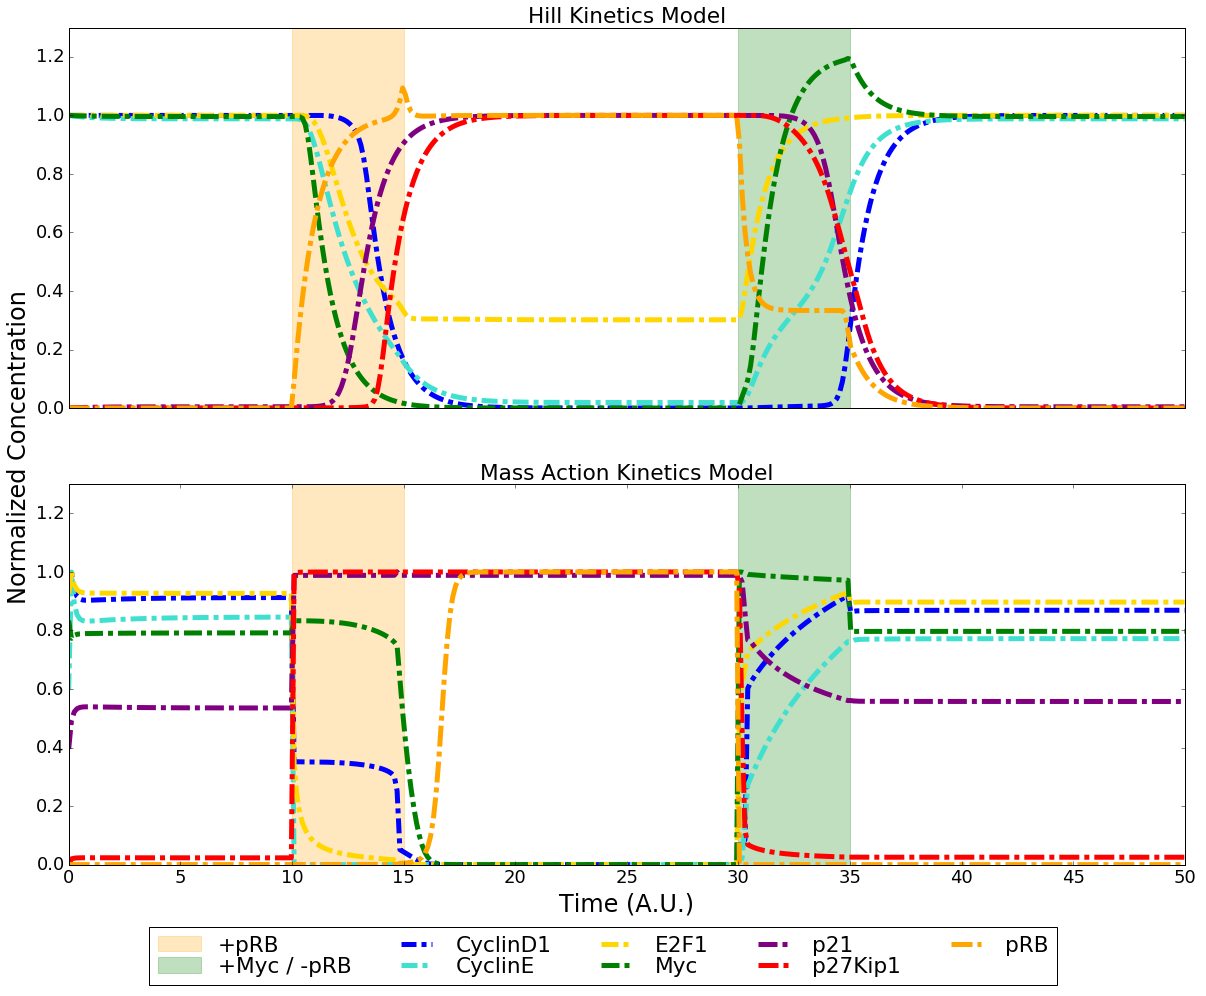

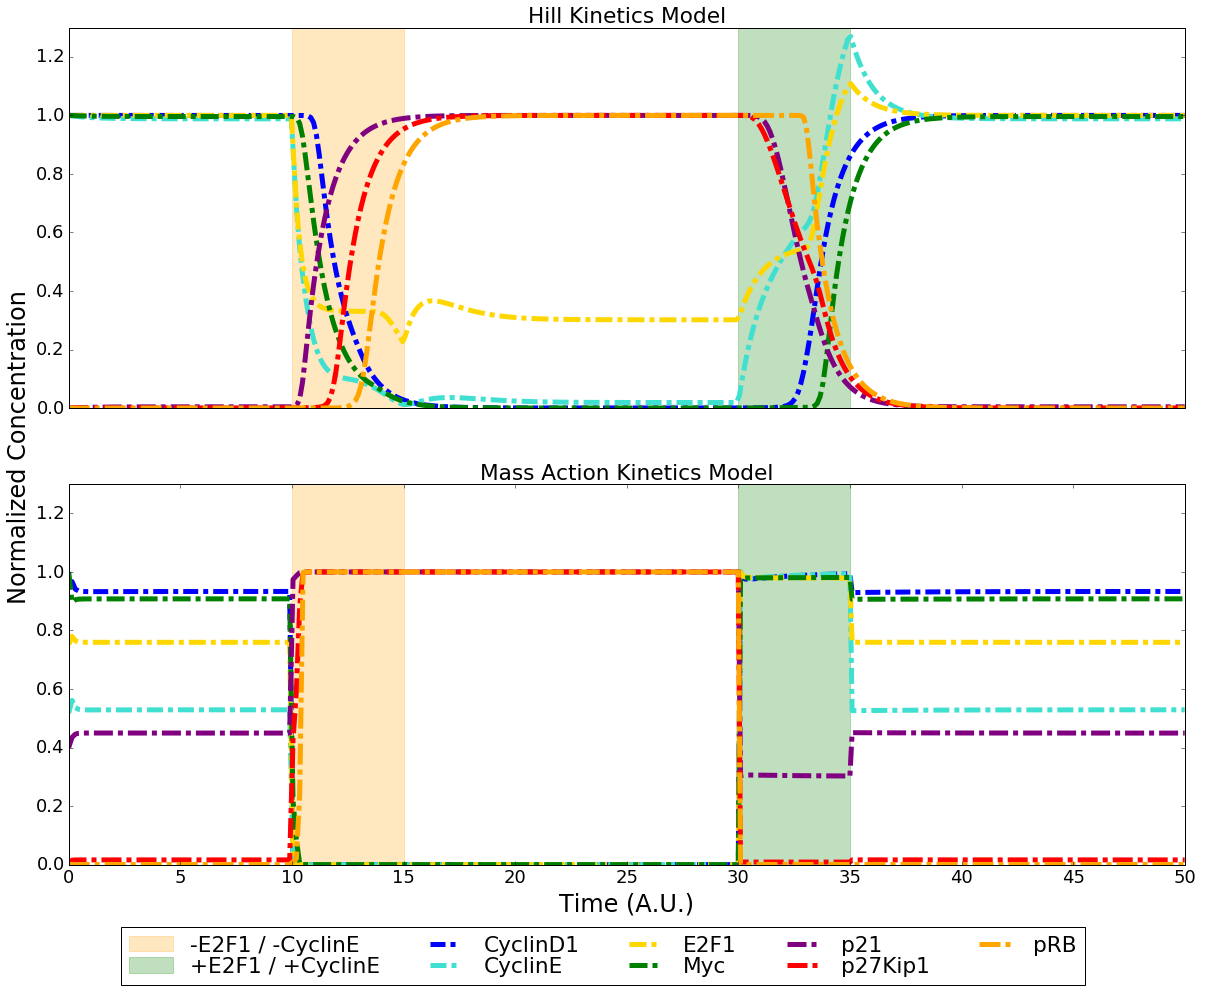

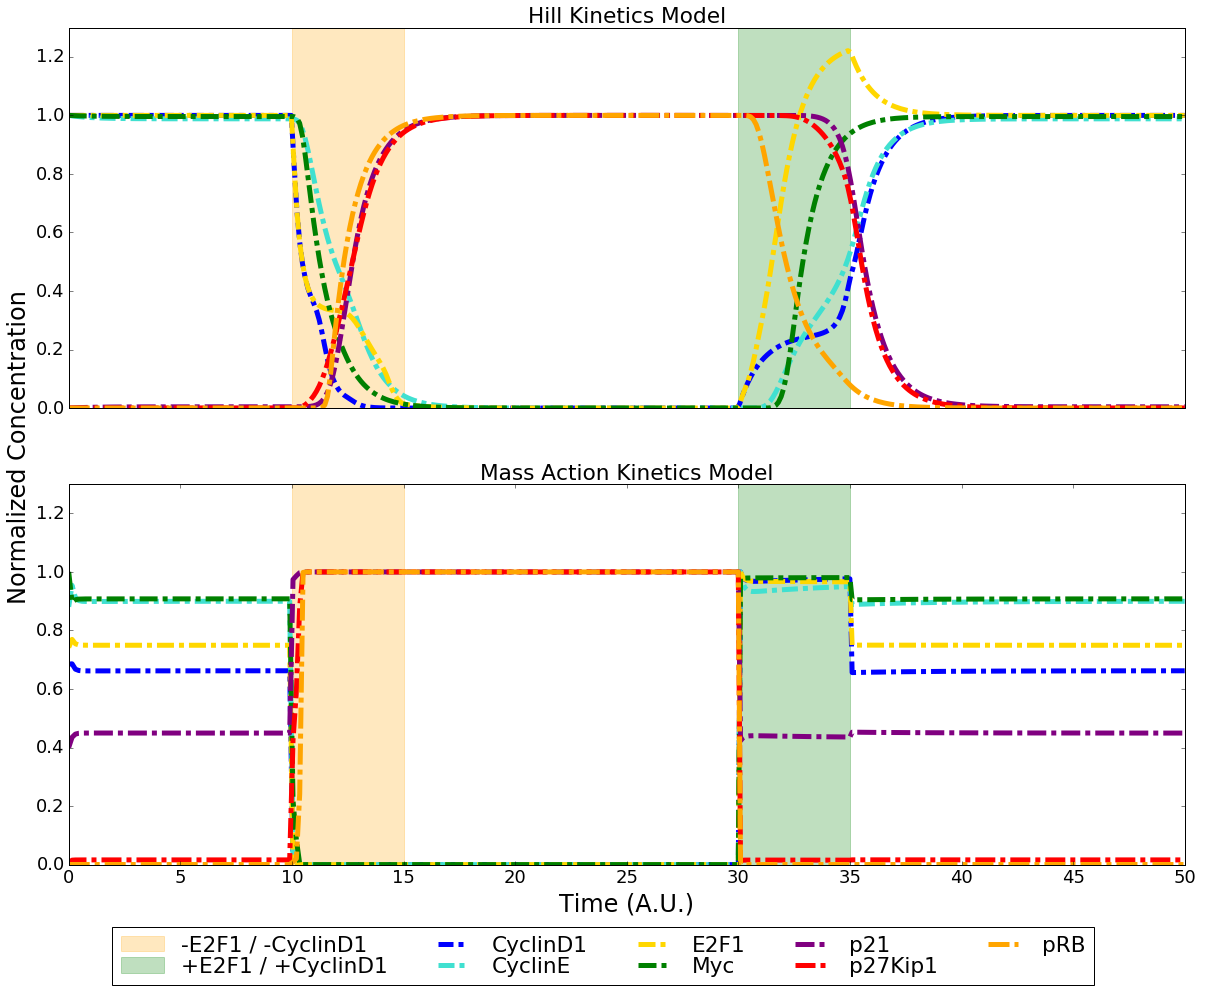

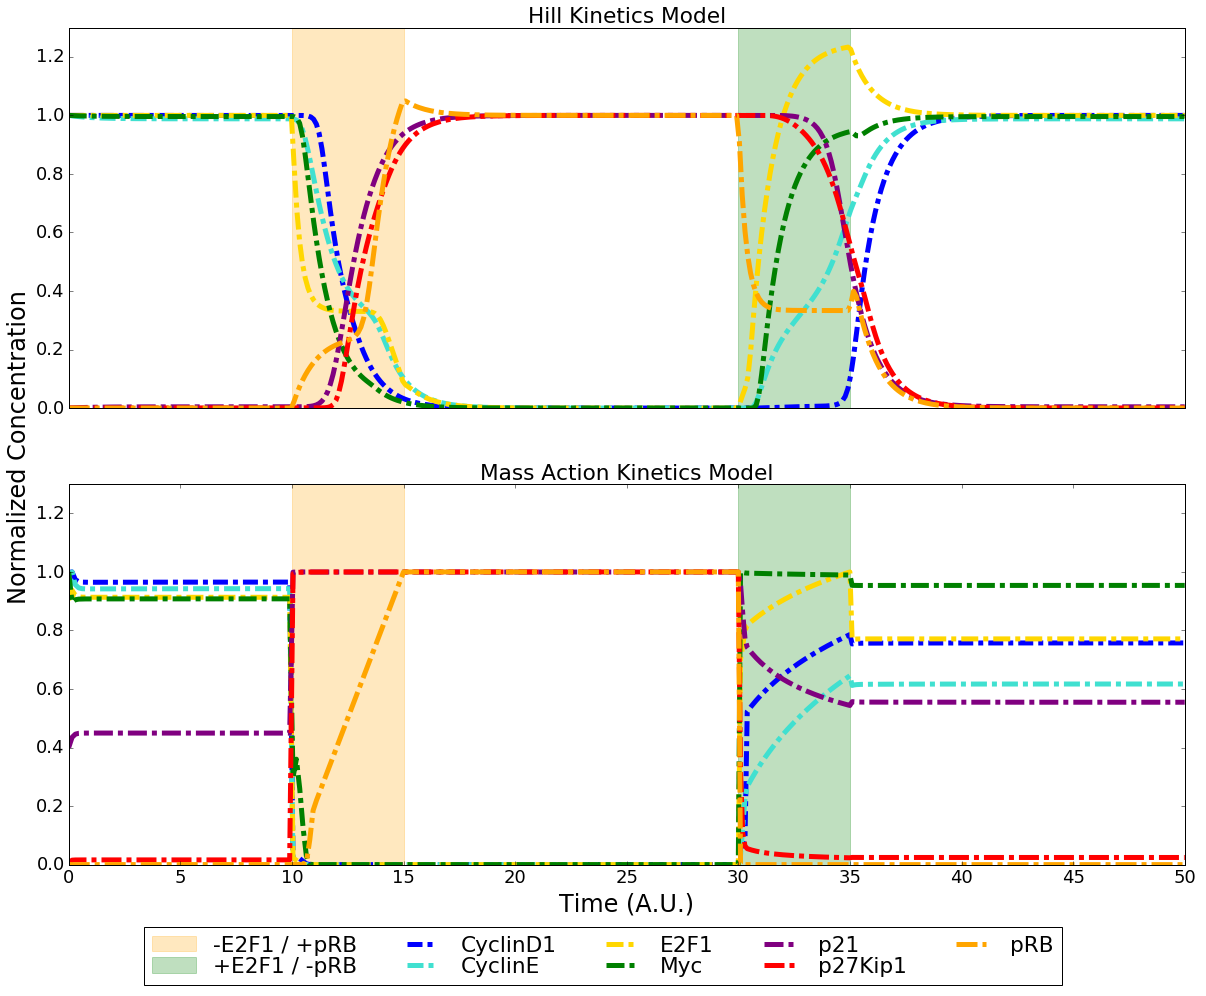

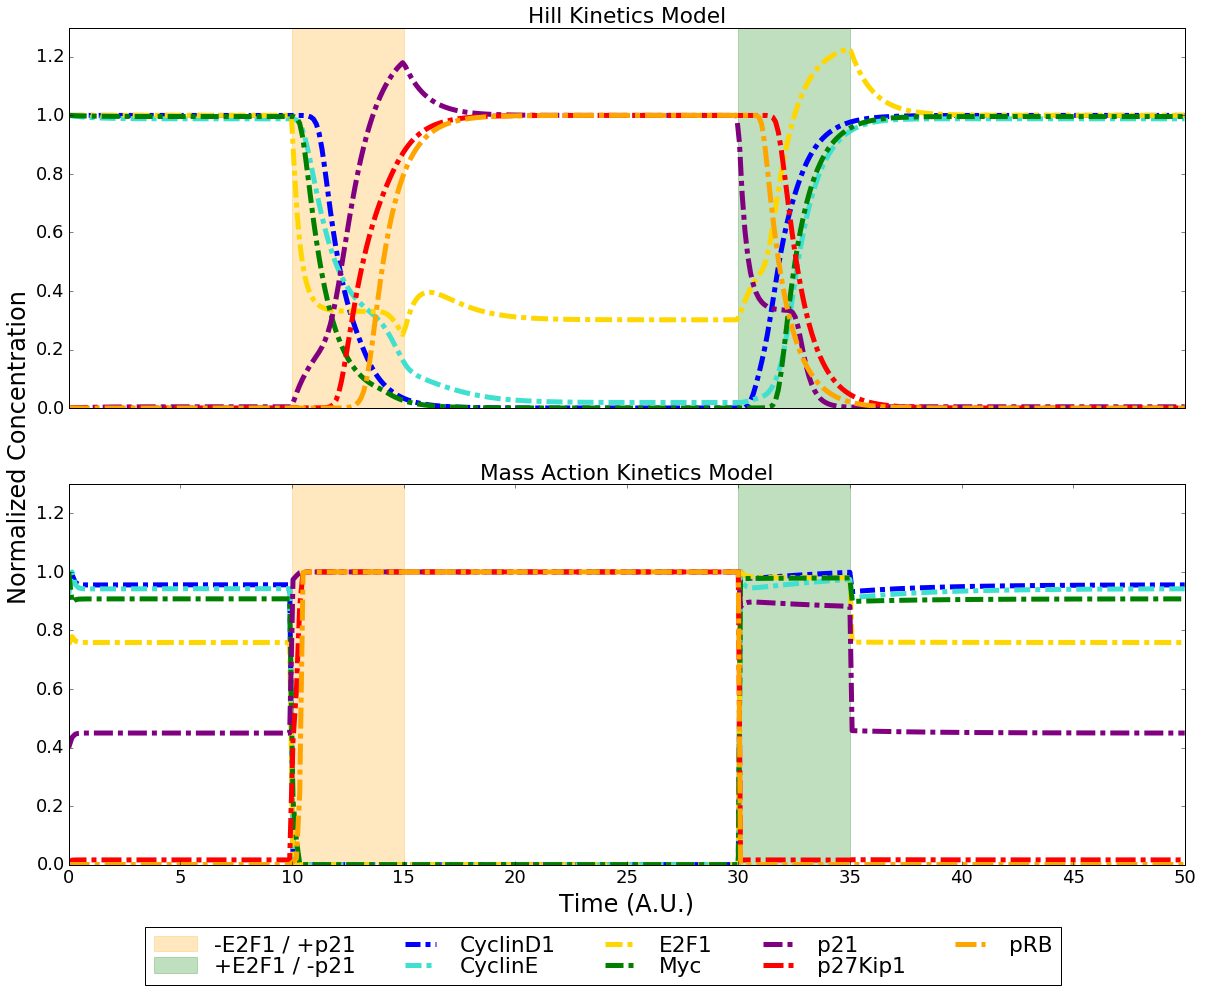

In [90]:
for i in range(0,len(sols)):
    plot_sol_yout(sols[i],youts[i],t,tts[i],ilabs[i],fnames[i])
